**Simple CNN**

In [4]:
os.getcwd()

'/home/jupyter/computer_vision'

In [ ]:
%%time
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


# Data paths
train_data_dir = "/home/jupyter/images_gcs/Data/train"
test_data_dir = "/home/jupyter/images_gcs/Data/test"



# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_directory(
    train_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)
test_generator = datagen.flow_from_directory(
    test_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)

# Build the CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters and ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Flatten(),  # Flatten layer
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])


# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model
history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping, tensorboard])

# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate performance metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save the model
model.save("cnn_base_model_20ep.keras")

Found 5713 images belonging to 36 classes.
Found 1400 images belonging to 36 classes.
Epoch 1/20
179/179 [==============================] - 226s 1s/step - loss: 3.6460 - accuracy: 0.0838 - val_loss: 3.3626 - val_accuracy: 0.1164
Epoch 2/20
179/179 [==============================] - 244s 1s/step - loss: 3.2117 - accuracy: 0.1619 - val_loss: 3.1707 - val_accuracy: 0.1743
Epoch 3/20
179/179 [==============================] - 237s 1s/step - loss: 2.8929 - accuracy: 0.2479 - val_loss: 3.0299 - val_accuracy: 0.2071
Epoch 4/20
179/179 [==============================] - 240s 1s/step - loss: 2.6685 - accuracy: 0.3065 - val_loss: 3.0394 - val_accuracy: 0.2393
Epoch 5/20
179/179 [==============================] - 239s 1s/step - loss: 2.4537 - accuracy: 0.3609 - val_loss: 2.9561 - val_accuracy: 0.2521
Epoch 6/20
179/179 [==============================] - 240s 1s/step - loss: 2.3343 - accuracy: 0.3907 - val_loss: 2.9402 - val_accuracy: 0.2679
Epoch 7/20
179/179 [==============================] - 23

In [10]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("cnn_base_model_20ep.keras")

# Display the model summary
loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (None, 36)               

**Pulls Accuracy for Class**

44/44 [==============================] - 50s 1s/step


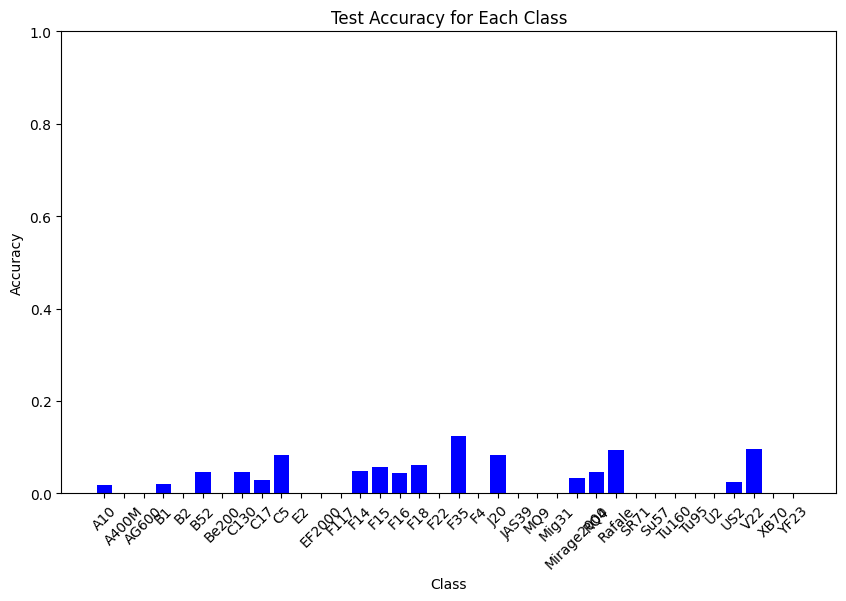

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model = load_model("cnn_base_model.keras")

# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate accuracy for each class
class_labels = list(test_generator.class_indices.keys())
class_accuracy = []

for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(y_true) == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_true[class_indices]
    class_accuracy.append(accuracy_score(class_true, class_pred))

# Plot the test accuracy for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='blue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


**Paramater Info**

In [8]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("/content/drive/MyDrive/CNN_Model3")

# Display the model summary
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 128)      

**Transfer Learning**

**Pre-trained with custom layer exactly the same as the best scratch model**

Need to change trage size in code below

Found 5713 images belonging to 36 classes.
Found 1400 images belonging to 36 classes.
Found 1420 images belonging to 36 classes.
Epoch 1/100
179/179 [==============================] - 108s 590ms/step - loss: 28.7392 - accuracy: 0.0616 - val_loss: 28.5413 - val_accuracy: 0.0458
Epoch 2/100
179/179 [==============================] - 105s 583ms/step - loss: 27.6982 - accuracy: 0.0982 - val_loss: 28.2883 - val_accuracy: 0.0465
Epoch 3/100
179/179 [==============================] - 106s 585ms/step - loss: 26.7441 - accuracy: 0.1302 - val_loss: 26.6581 - val_accuracy: 0.0683
Epoch 4/100
179/179 [==============================] - 105s 585ms/step - loss: 25.7289 - accuracy: 0.1682 - val_loss: 25.3497 - val_accuracy: 0.1408
Epoch 5/100
179/179 [==============================] - 105s 585ms/step - loss: 24.7397 - accuracy: 0.2013 - val_loss: 24.3802 - val_accuracy: 0.2000
Epoch 6/100
179/179 [==============================] - 105s 580ms/step - loss: 23.7100 - accuracy: 0.2489 - val_loss: 23.3791 

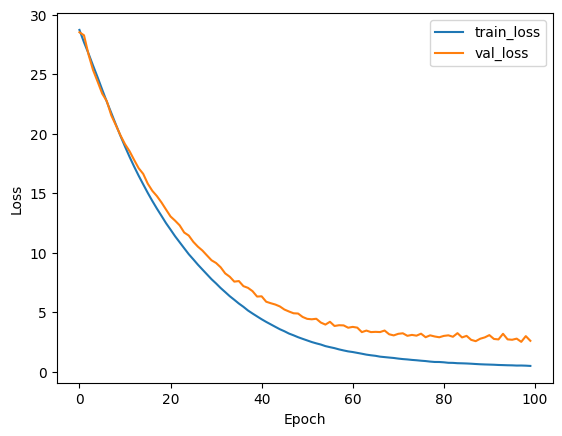

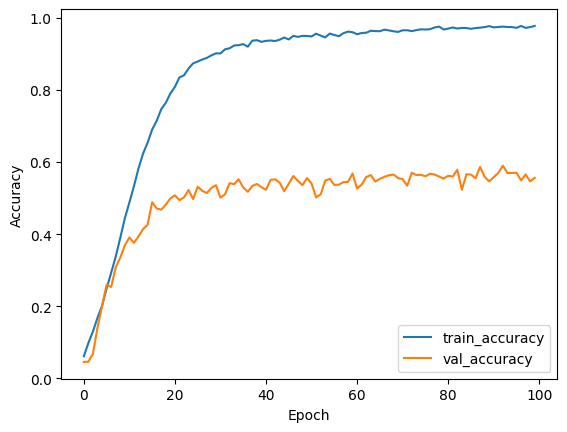

45/45 [==============================] - 15s 333ms/step - loss: 2.6339 - accuracy: 0.5535
Validation Loss: 2.6339097023010254
Validation Accuracy: 0.5535211563110352
45/45 [==============================] - 16s 341ms/step
Validation Precision: 0.5873752635585794
Validation Recall: 0.5591549295774648
Validation F1 Score: 0.5624208687490821
44/44 [==============================] - 48s 1s/step - loss: 2.6858 - accuracy: 0.5471
Test Loss: 2.685786008834839
Test Accuracy: 0.5471428632736206
44/44 [==============================] - 15s 337ms/step
Test Precision: 0.5879135481286584
Test Recall: 0.5607142857142857
Test F1 Score: 0.559785129199076


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

def custom_block(model, filters, kernel_size, block_size):
    for _ in range(block_size):
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    return model

from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import L2
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Data paths
train_data_dir = "/home/jupyter/images_gcs/Data/train"
test_data_dir = "/home/jupyter/images_gcs/Data/test"
val_data_dir = "/home/jupyter/images_gcs/Data/val"

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_directory(
    train_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True, seed=42
)
test_generator = datagen.flow_from_directory(
    test_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)
val_generator = datagen.flow_from_directory(
    val_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# Create the model
model = Sequential()

# Load the EfficientNetB3 model pre-trained on ImageNet without the top (classification) layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add Block 1
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01), input_shape=(224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Add Block 2
model = custom_block(model, filters=128, kernel_size=(3,3), block_size=3)

# Add Block 3
model = custom_block(model, filters=256, kernel_size=(3,3), block_size=3)

# Add Block 4
model = custom_block(model, filters=512, kernel_size=(3,3), block_size=3)

# Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Softmax
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.00004),
    metrics=['accuracy']
)

# Fit the model
history = model.fit(train_generator,
                    workers=8,
                    epochs=100, 
                    validation_data=val_generator, 
                    callbacks=[early_stopping, tensorboard])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate performance metrics for validation set
val_pred = np.argmax(model.predict(val_generator), axis=-1)
val_true = val_generator.classes

val_precision = precision_score(val_true, val_pred, average='weighted')
val_recall = recall_score(val_true, val_pred, average='weighted')
val_f1 = f1_score(val_true, val_pred, average='weighted')

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict labels for the test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate performance metrics for the test set
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

# Save the model
model.save("EfficientNetB0_Model.keras")


44/44 [==============================] - 50s 1s/step


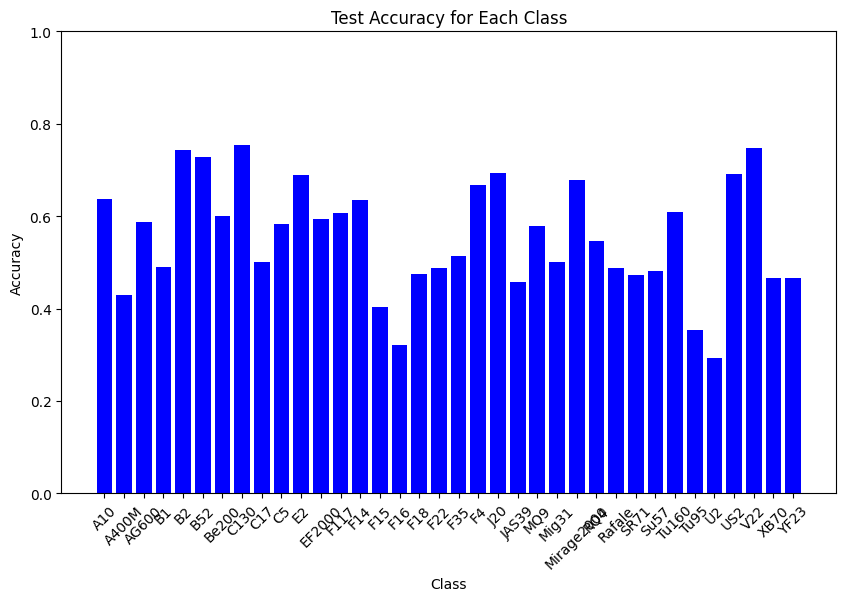

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.models import load_model


model = load_model("EfficientNetB0_Model.keras")

# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate accuracy for each class
class_labels = list(test_generator.class_indices.keys())
class_accuracy = []

for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(y_true) == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_true[class_indices]
    class_accuracy.append(accuracy_score(class_true, class_pred))

# Plot the test accuracy for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='blue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


In [12]:
accuracy_score(y_pred, y_true)

0.5564285714285714

In [13]:
from keras.models import load_model

loaded_model = load_model("EfficientNetB0_Model.keras")

# Display the model summary
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_37 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 conv2d_38 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 112, 112, 128)    

## B7 Attempt

Found 5713 images belonging to 36 classes.
Found 1400 images belonging to 36 classes.
Found 1420 images belonging to 36 classes.
Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 28.7440 - accuracy: 0.0646

2024-02-21 19:06:45.082678: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 122s 635ms/step - loss: 28.7440 - accuracy: 0.0646 - val_loss: 28.4386 - val_accuracy: 0.0458
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 27.7383 - accuracy: 0.0935

2024-02-21 19:07:36.012382: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 51s 276ms/step - loss: 27.7383 - accuracy: 0.0935 - val_loss: 27.6992 - val_accuracy: 0.0352
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 26.8064 - accuracy: 0.1315

2024-02-21 19:08:19.689561: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 44s 240ms/step - loss: 26.8064 - accuracy: 0.1315 - val_loss: 26.7534 - val_accuracy: 0.0676
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 25.8374 - accuracy: 0.1766

2024-02-21 19:09:04.039381: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 45s 245ms/step - loss: 25.8374 - accuracy: 0.1766 - val_loss: 25.5478 - val_accuracy: 0.1662
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 24.8497 - accuracy: 0.2079

2024-02-21 19:09:47.182753: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 43s 236ms/step - loss: 24.8497 - accuracy: 0.2079 - val_loss: 24.5432 - val_accuracy: 0.1866
Epoch 6/100
179/179 [==============================] - 43s 238ms/step - loss: 23.8653 - accuracy: 0.2598 - val_loss: 23.5119 - val_accuracy: 0.2655
Epoch 7/100
179/179 [==============================] - 43s 239ms/step - loss: 22.8697 - accuracy: 0.3035 - val_loss: 22.6675 - val_accuracy: 0.2613
Epoch 8/100
179/179 [==============================] - 44s 240ms/step - loss: 21.9184 - accuracy: 0.3564 - val_loss: 21.9070 - val_accuracy: 0.2845
Epoch 9/100
179/179 [==============================] - 43s 237ms/step - loss: 20.9570 - accuracy: 0.4038 - val_loss: 21.0339 - val_accuracy: 0.3092
Epoch 10/100
179/179 [==============================] - 48s 263ms/step - loss: 20.0501 - accuracy: 0.4556 - val_loss: 20.1581 - val_accuracy: 0.3704
Epoch 11/100
179/179 [==============================] - 44s 241ms/step - loss: 19.1377 - accuracy: 0.5001 - val_loss: 19.40

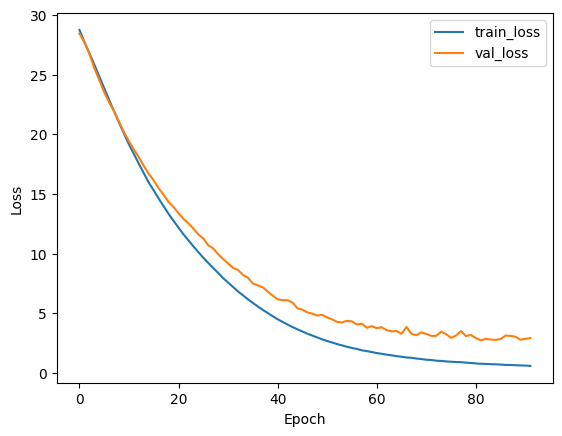

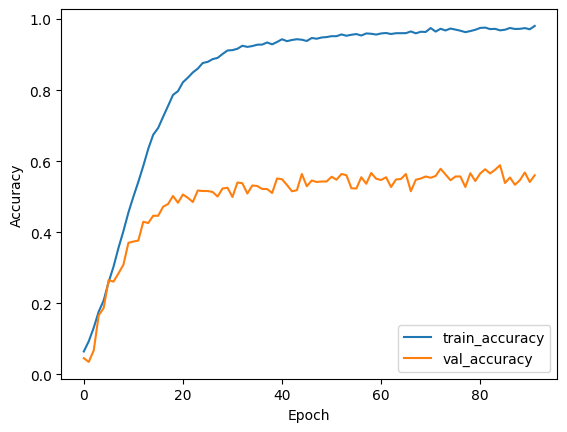

45/45 [==============================] - 15s 330ms/step - loss: 2.6800 - accuracy: 0.5732
Validation Loss: 2.6800410747528076
Validation Accuracy: 0.5732394456863403
45/45 [==============================] - 15s 328ms/step
Validation Precision: 0.612051443092011
Validation Recall: 0.5746478873239437
Validation F1 Score: 0.5808956917621806
44/44 [==============================] - 137s 3s/step - loss: 2.7462 - accuracy: 0.5614
Test Loss: 2.7462310791015625
Test Accuracy: 0.5614285469055176
44/44 [==============================] - 43s 998ms/step
Test Precision: 0.597443959896669
Test Recall: 0.5692857142857143
Test F1 Score: 0.56936782316418


In [4]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

def custom_block(model, filters, kernel_size, block_size):
    for _ in range(block_size):
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    return model

from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import L2
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Data paths
train_data_dir = "/home/jupyter/images_gcs/Data/train"
test_data_dir = "/home/jupyter/images_gcs/Data/test"
val_data_dir = "/home/jupyter/images_gcs/Data/val"

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_directory(
    train_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True, seed=42
)
test_generator = datagen.flow_from_directory(
    test_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)
val_generator = datagen.flow_from_directory(
    val_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# Create the model
model = Sequential()

# Load the EfficientNetB3 model pre-trained on ImageNet without the top (classification) layer
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add Block 1
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01), input_shape=(224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Add Block 2
model = custom_block(model, filters=128, kernel_size=(3,3), block_size=3)

# Add Block 3
model = custom_block(model, filters=256, kernel_size=(3,3), block_size=3)

# Add Block 4
model = custom_block(model, filters=512, kernel_size=(3,3), block_size=3)

# Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Softmax
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.00004),
    metrics=['accuracy']
)

# Fit the model
history = model.fit(train_generator,
                    workers=6,
                    epochs=100, 
                    validation_data=val_generator, 
                    callbacks=[early_stopping, tensorboard])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate performance metrics for validation set
val_pred = np.argmax(model.predict(val_generator), axis=-1)
val_true = val_generator.classes

val_precision = precision_score(val_true, val_pred, average='weighted')
val_recall = recall_score(val_true, val_pred, average='weighted')
val_f1 = f1_score(val_true, val_pred, average='weighted')

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict labels for the test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate performance metrics for the test set
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

# Save the model
model.save("EfficientNetB7_Model.keras")


44/44 [==============================] - 18s 403ms/step


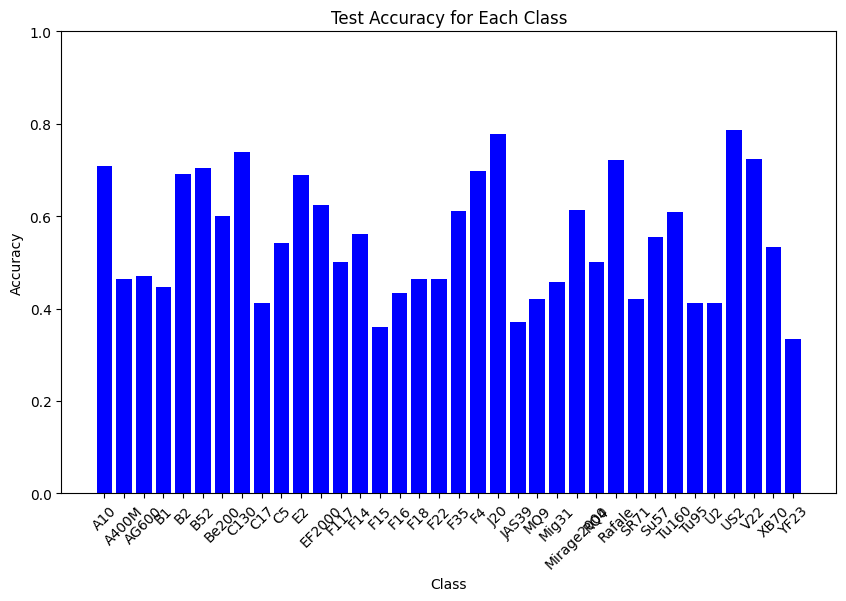

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.models import load_model


model = load_model("EfficientNetB7_Model.keras")

# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate accuracy for each class
class_labels = list(test_generator.class_indices.keys())
class_accuracy = []

for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(y_true) == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_true[class_indices]
    class_accuracy.append(accuracy_score(class_true, class_pred))

# Plot the test accuracy for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='blue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


## ResNet50

In [10]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization


from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import L2
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Feature extraction layer
# (a) Input processing
preprocess_input = resnet50.preprocess_input

# (b) create base model using ResNet50

base_model = ResNet50(input_shape=(224,224,3),
                                   include_top=False,
                                   weights='imagenet')

# (c) Freeze layers
base_model.trainable = False
base_model.summary()

# (d) Classification layer
nClass = len(train_generator.class_indices)

global_avg = GlobalAveragePooling2D()
output_layer = Dense(nClass, activation='softmax')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [80]:
# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = tf.keras.utils.image_dataset_from_directory(
    train_data_dir, image_size=(224, 224), batch_size=32, labels="inferred", shuffle=True, seed=42
)
test_generator = tf.keras.utils.image_dataset_from_directory(
    test_data_dir, image_size=(224, 224), batch_size=32, labels="inferred", shuffle=False
)
val_generator = tf.keras.utils.image_dataset_from_directory(
    val_data_dir, image_size=(224, 224), batch_size=29, labels="inferred", shuffle=False
)

Found 5713 files belonging to 36 classes.
Found 1400 files belonging to 36 classes.
Found 1420 files belonging to 36 classes.


In [81]:
# Create prefetch for train,test,val data
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_generator.prefetch(buffer_size=AUTOTUNE)
pf_test = test_generator.prefetch(buffer_size=AUTOTUNE)
pf_val = val_generator.prefetch(buffer_size=AUTOTUNE)

In [49]:
# Augmentation layer
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.4))

In [50]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(224,224,3))
x = preprocess_input(inputs)
x = data_augmentation(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 36)                73764     
                                                                 
Total params: 23,661,476
Trainable params: 73,764
Non-trainable params: 23,587,712
__________________________________________

In [51]:
from tensorflow.keras import optimizers, losses, layers
# Compile model
lr_schedule = optimizers.schedules.CosineDecay(0.001, 500)
optimizer = optimizers.Adam(learning_rate=lr_schedule)
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [52]:
# Train Model
EPOCHS = 5
history = model.fit(train_generator,
                    workers=6,
                    validation_data=val_generator, 
                    epochs=EPOCHS)

Epoch 1/5


2024-02-21 20:43:53.562940: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55ff31e01330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 20:43:53.562980: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-02-21 20:43:53.683262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/179 [..............................] - ETA: 20:56 - loss: 4.1887 - accuracy: 0.0625

2024-02-21 20:43:54.437133: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 [==============================] - 55s 270ms/step - loss: 3.1144 - accuracy: 0.1885 - val_loss: 2.6757 - val_accuracy: 0.2761
Epoch 2/5
179/179 [==============================] - 38s 205ms/step - loss: 2.2367 - accuracy: 0.3819 - val_loss: 2.4378 - val_accuracy: 0.3176
Epoch 3/5
179/179 [==============================] - 37s 204ms/step - loss: 2.0060 - accuracy: 0.4544 - val_loss: 2.4172 - val_accuracy: 0.3366
Epoch 4/5
179/179 [==============================] - 38s 206ms/step - loss: 1.9879 - accuracy: 0.4516 - val_loss: 2.4172 - val_accuracy: 0.3366
Epoch 5/5
179/179 [==============================] - 37s 202ms/step - loss: 1.9881 - accuracy: 0.4577 - val_loss: 2.4172 - val_accuracy: 0.3366


## Let's Fine Tune Model

In [55]:
# Finetune layer of base model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile model
optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [56]:
# Continue model training
fine_tune_epoch = 1
NEW_EPOCH = EPOCHS + fine_tune_epoch

history_fine = model.fit(pf_train,
                         validation_data=(pf_val),
                         epochs=NEW_EPOCH,
                         initial_epoch=history.epoch[-1])

Epoch 5/6
179/179 [==============================] - 55s 241ms/step - loss: 1.6697 - accuracy: 0.5213 - val_loss: 2.0274 - val_accuracy: 0.4831
Epoch 6/6
179/179 [==============================] - 40s 218ms/step - loss: 0.9176 - accuracy: 0.7373 - val_loss: 1.1067 - val_accuracy: 0.6754


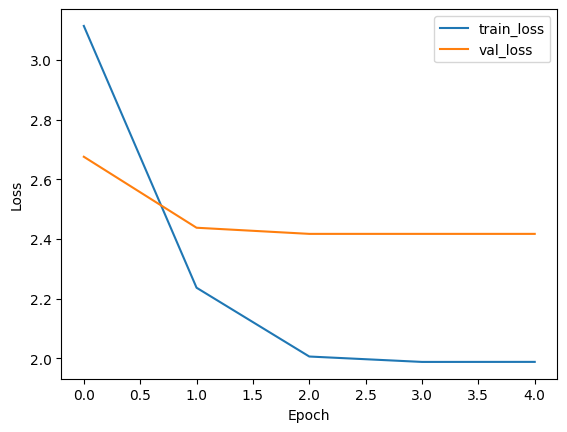

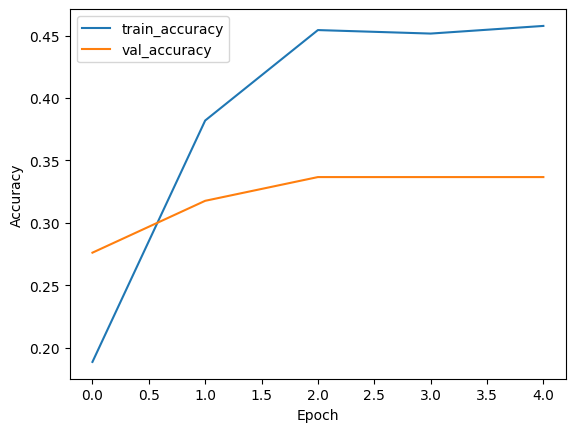

In [62]:
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# Save the model
model.save("ResNet50_Model.keras")


In [74]:
test_loss, test_accuracy = model.evaluate(pf_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

44/44 [==============================] - 30s 655ms/step - loss: 1.1262 - accuracy: 0.6679
Test Loss: 1.1262247562408447
Test Accuracy: 0.6678571701049805


In [114]:
test_label = np.concatenate([y for x, y in pf_test], axis=0) 


In [115]:
# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_label

44/44 [==============================] - 1s 34ms/step


A10
A400M
AG600
B1
B2
B52
Be200
C130
C17
C5
E2
EF2000
F117
F14
F15
F16
F18
F22
F35
F4
J20
JAS39
MQ9
Mig31
Mirage2000
RQ4
Rafale
SR71
Su57
Tu160
Tu95
U2
US2
V22
XB70
YF23


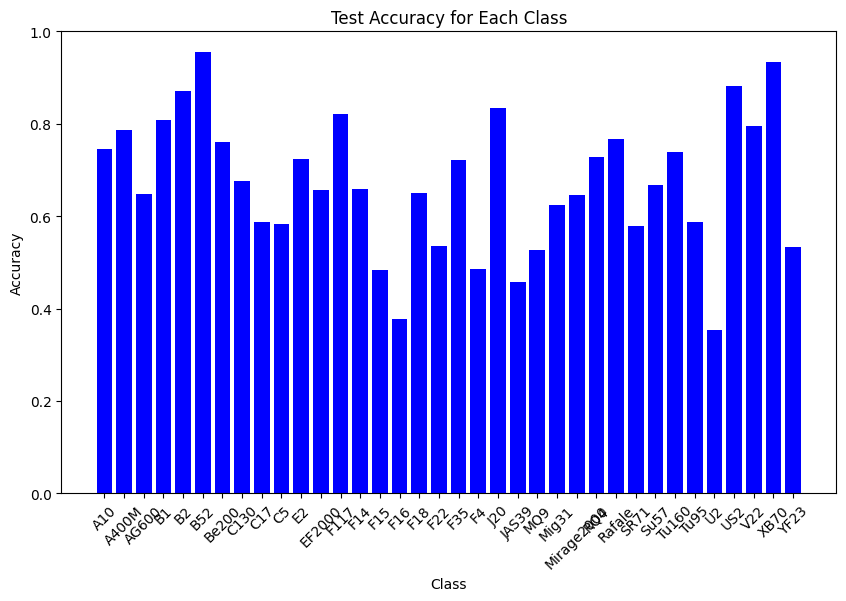

In [120]:
# Calculate accuracy for each class
class_labels = list(test_generator.class_names)
class_accuracy = []

for i, class_label in enumerate(class_labels):
    print(class_label)
    class_indices = np.where(np.array(y_true) == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_true[class_indices]
    class_accuracy.append(accuracy_score(class_true, class_pred))

# Plot the test accuracy for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='blue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

array([ 0,  0,  8, ..., 17, 34, 35])